# Transit Costs Estimate: based on GTFS and NTD

### Preparation: import package

In [1]:
# a handy trick to get rid of deprecation warnings
import warnings
warnings.filterwarnings("ignore") 

The following package is particularly applicable to general and Step A

In [2]:
from configparser import ConfigParser
import matplotlib.pyplot as plt
import pandas as pd
from census import Census
from us import states
import pyproj
import geopandas as gpd
import numpy as np

The following package is particularly applicable to Step B

In [3]:
import gtfs_kit as gk
from geopandas import GeoDataFrame
from shapely.geometry import Point
import zipfile

The following package is particularly applicable to mapping part

In [4]:
from matplotlib.path import Path
import matplotlib.patheffects as PathEffects
from matplotlib import patheffects
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from matplotlib_scalebar.scalebar import ScaleBar
import palettable.matplotlib as mplpal
import palettable.colorbrewer.sequential as mplpals
from legendgram import legendgram
import mapclassify # used for reproducing the group of data in natural breaks
%matplotlib inline

### Preparation: updated stored files or links

In [5]:
# Read all environment variables
config = ConfigParser()
config.readfp(open(r'Config.py'))

census_api = config.get('General',"census_api") # api key
tx_state = config.get('General',"tx_state") #tx_state shapefile
tx_county  = config.get('General',"tx_county") # tx_county shapefile
tx_bgs = config.get('General',"tx_bgs") # tx_bgs shapefile

capmetro_gtfs = config.get('Transit',"capmetro_gtfs") #CapMetro GTFS data
carts_stops = config.get('Transit',"carts_stops")# Carts Transit stops

In [6]:
# Set ACS API key
c = Census(census_api) 

In [7]:
# Access shapefile of Texas state
tx_state = gpd.read_file(tx_state) 

# Access shapefile of Texas county
tx_county = gpd.read_file(tx_county)

# Access shapefile of Texas census block groups
tx_bgs = gpd.read_file(tx_bgs)

In [8]:
### load CapMetro GTFS data 
zf = zipfile.ZipFile(capmetro_gtfs)  

In [9]:
### load CARTS stops information (Note: you need to enter your own directory path)
carts = pd.read_csv(carts_stops) 

## A. Download ACS data and corresponding geometry at county level

### A.1) import acs data

In [10]:
#Load Campo region' data at county level
tx_census = c.acs5.state_county(fields = ('NAME', 'B08301_003E'), #using any one of the variables should be ok
                                      state_fips = states.TX.fips,
                                      county_fips = "*",
                                      year = 2019)

In [11]:
# Create a dataframe for the downloaded census data
tx_df = pd.DataFrame(tx_census)

# filter needed county 
# (CAMPO's counties fips:#Bastrop =021,Burnet=053,Caldwell=055,Hays =209,Travis=453,Williamson = 491)

county = ['021', '053', '055','209','453','491']
tx_df = tx_df[tx_df['county'].isin(county)] 

# Show the dataframe
print(tx_df.head(2))
print('Shape: ', tx_df.shape)

tx_df.info()

                     NAME  B08301_003E state county
26   Travis County, Texas     502207.0    48    453
73  Bastrop County, Texas      28560.0    48    021
Shape:  (6, 4)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 26 to 169
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   NAME         6 non-null      object 
 1   B08301_003E  6 non-null      float64
 2   state        6 non-null      object 
 3   county       6 non-null      object 
dtypes: float64(1), object(3)
memory usage: 240.0+ bytes


### A.2) import shapefile from tiger

In [12]:
### Access shapefile of Texas county ###

# Reproject shapefile to the EPSG identifier of NAD83 
tx_county = tx_county.to_crs(epsg = 4269)

# Print GeoDataFrame of shapefile
print(tx_county.head(2))
print('Shape: ', tx_county.shape)

# Check shapefile projection
print("\nThe shapefile projection is: {}".format(tx_county.crs))

  STATEFP COUNTYFP  COUNTYNS  GEOID       NAME          NAMELSAD LSAD CLASSFP  \
0      31      039  00835841  31039     Cuming     Cuming County   06      H1   
1      53      069  01513275  53069  Wahkiakum  Wahkiakum County   06      H1   

   MTFCC CSAFP CBSAFP METDIVFP FUNCSTAT       ALAND    AWATER     INTPTLAT  \
0  G4020  None   None     None        A  1477652222  10690952  +41.9158651   
1  G4020  None   None     None        A   680962890  61582307  +46.2946377   

       INTPTLON                                           geometry  
0  -096.7885168  POLYGON ((-97.01952 42.00410, -97.01952 42.004...  
1  -123.4244583  POLYGON ((-123.43639 46.23820, -123.44759 46.2...  
Shape:  (3233, 18)

The shapefile projection is: epsg:4269


### A.3) Get geometry for our target counties

Create GEOID for each county


In [13]:
# Combine state and county columns to create a new string and assign it to a new column

tx_df["GEOID"] = tx_df["state"] + tx_df["county"]

In [14]:
tx_df.head(6) # check data

,NAME,B08301_003E,state,county,GEOID
26,"Travis County, Texas",502207.0,48,453,48453
73,"Bastrop County, Texas",28560.0,48,021,48021
79,"Caldwell County, Texas",14641.0,48,055,48055
153,"Hays County, Texas",85971.0,48,209,48209
163,"Williamson County, Texas",218899.0,48,491,48491
169,"Burnet County, Texas",15592.0,48,053,48053


In [15]:
# Remove columns that are no longer needed
tx_df = tx_df.drop(columns = ["state", "county"])

# Show updated dataframe
tx_df.head(6)

,NAME,B08301_003E,GEOID
26,"Travis County, Texas",502207.0,48453
73,"Bastrop County, Texas",28560.0,48021
79,"Caldwell County, Texas",14641.0,48055
153,"Hays County, Texas",85971.0,48209
163,"Williamson County, Texas",218899.0,48491
169,"Burnet County, Texas",15592.0,48053


Merge dataframes: join the two dataframes (acs and tiger shapefile)

In [16]:
# Join the attributes of the dataframes together
# Source: https://geopandas.org/docs/user_guide/mergingdata.html
tx_merge = tx_county.merge(tx_df, on = "GEOID")

# Show result
print(tx_merge.head(2))
print('Shape: ', tx_merge.shape);

  STATEFP COUNTYFP  COUNTYNS  GEOID    NAME_x         NAMELSAD LSAD CLASSFP  \
0      48      055  01383813  48055  Caldwell  Caldwell County   06      H1   
1      48      209  01383890  48209      Hays      Hays County   06      H1   

   MTFCC CSAFP CBSAFP METDIVFP FUNCSTAT       ALAND   AWATER     INTPTLAT  \
0  G4020  None  12420     None        A  1412165279  4958570  +29.8323986   
1  G4020  None  12420     None        A  1756075985  4940666  +30.0612247   

       INTPTLON                                           geometry  \
0  -097.6281410  POLYGON ((-97.82291 29.93163, -97.82233 29.931...   
1  -098.0292673  POLYGON ((-98.15159 29.93432, -98.15161 29.934...   

                   NAME_y  B08301_003E  
0  Caldwell County, Texas      14641.0  
1      Hays County, Texas      85971.0  
Shape:  (6, 20)


## B. Download GTFS data and corresponding geometry 

* Before loading the data, you should first Download GTFS data from gov website.CapMetro:(https://data.texas.gov/Transportation/CapMetro-GTFS/r4v4-vz24)
* For CARTS did not post GTFS data, we manually geocoded transit stops
* Save the file to your working folder, so that we can declare the directory path for it

In [17]:
### load CapMetro GTFS data ###

#open our target CapMetro file named "stops"
gtfs = pd.read_csv(zf.open('stops.txt'))
gtfs = gtfs[['stop_id','stop_lat','stop_lon']] # only keep necessary columns

### load CARTS stops information### 
carts = carts[['stop_id','stop_lat','stop_lon']] # only keep necessary columns

#get a full list of transit stops locations in the CAMPO region
gtfs =  pd.concat([gtfs, carts],ignore_index=True)

In [18]:
gtfs # check data

,stop_id,stop_lat,stop_lon
0,243,30.278966,-97.746339
1,467,30.355296,-97.703128
2,468,30.353139,-97.706082
3,471,30.346044,-97.713966
4,472,30.343739,-97.715301
...,...,...,...
2437,46,29.876467,-97.941151
2438,47,30.007468,-97.157278
2439,48,30.576637,-98.272845
2440,49,30.178670,-97.526504


In [19]:
# format data
geometry = [Point(xy) for xy in zip(gtfs.stop_lon, gtfs.stop_lat)]
gtfs = gtfs.drop(['stop_lon', 'stop_lat'], axis=1)  #drop unnecessary columns
g_gtfs= GeoDataFrame(gtfs, crs="EPSG:4269", geometry=geometry)

g_gtfs.sort_values('stop_id')#check data

,stop_id,geometry
2392,1,POINT (-97.98579 29.82572)
2393,2,POINT (-97.94186 29.88752)
2394,3,POINT (-97.67973 30.63658)
2395,4,POINT (-97.68988 30.55583)
2396,5,POINT (-98.27716 30.57195)
...,...,...
2387,6456,POINT (-97.72256 30.38863)
2388,6458,POINT (-97.78177 30.24237)
2389,6459,POINT (-97.69801 30.25170)
2390,6460,POINT (-97.73050 30.26556)


## C. Spatial join ACS data and GTFS data

In [20]:
join=gpd.sjoin(tx_merge, g_gtfs)
join= join[['GEOID','geometry']] # only keep necessary columns
join.info()
join.shape

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 2438 entries, 0 to 5
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   GEOID     2438 non-null   object  
 1   geometry  2438 non-null   geometry
dtypes: geometry(1), object(1)
memory usage: 57.1+ KB


(2438, 2)

## D. Estimate the transit revenue for each county

Count the total transit stops in each county, then get the percentage of transit revenue received by each county

In [21]:
# specify that each stop_ID occurs once in the dataset
join["stops"] = 1

#Count the total transit stops in each county
stops = join.groupby('GEOID',as_index=False).sum()
print(stops.head(6))  


   GEOID  stops
0  48021      7
1  48053      6
2  48055      4
3  48209     22
4  48453   2272
5  48491    127


In [22]:
#  get the percentage of transit revenue received by each county based on the stops proportion
revenue = stops.copy() #get a new copy to avoid data clutter 
revenue ["revenue_percent"] =  revenue ["stops"] / revenue ["stops"].sum()

 # get the transit revenue allocated to each county
revenue ["transit_revenue"] =  23278489 * revenue ["revenue_percent"] ##according to NTD, total fare revenue is $23,278,489

revenue.round(2)

,GEOID,stops,revenue_percent,transit_revenue
0,48021,7,0.00,66837.34
1,48053,6,0.00,57289.14
2,48055,4,0.00,38192.76
3,48209,22,0.01,210060.20
4,48453,2272,0.93,21693489.34
5,48491,127,0.05,1212620.22


## E. Assign transit revenue at the block group level

In [23]:
###Load Campo region's ACS Data at the block groups level###

# census data download
bgs_census = c.acs5.state_county_blockgroup(fields = ('NAME', 'B08301_010E',"B11001_001E"), #public_transit users "B08301_010", number of household = "B11001_001"
                                            state_fips = states.TX.fips,
                                            county_fips = "*",
                                            blockgroup = "*",
                                            year = 2019)
# Create a dataframe for the downloaded census data
bgs_census = pd.DataFrame(bgs_census)


# filter needed county 
# (CAMPO's counties fips:#Bastrop =021,Burnet=053,Caldwell=055,Hays =209,Travis=453,Williamson = 491)

county = ['021', '053', '055','209','453','491']
bgs_census = bgs_census[bgs_census['county'].isin(county)] 

# Show the dataframe
print('Shape: ', bgs_census.shape)
bgs_census.info() # review data

Shape:  (994, 7)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 994 entries, 192 to 15758
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   NAME         994 non-null    object 
 1   B08301_010E  994 non-null    float64
 2   B11001_001E  994 non-null    float64
 3   state        994 non-null    object 
 4   county       994 non-null    object 
 5   tract        994 non-null    object 
 6   block group  994 non-null    object 
dtypes: float64(2), object(5)
memory usage: 62.1+ KB


### E.1)  Download ACS data and corresponding geometry at block group level


Create GEOID for each block groups:

In [24]:

# Combine state, county, tract, and block group columns to create a new string and assign it to a new column
bgs_census["GEOID"] = bgs_census["state"] + bgs_census["county"] 

bgs_census["geoid_bgs"] = bgs_census["state"] + bgs_census["county"] + bgs_census ["tract"] + bgs_census ["block group"]

# Remove columns that are no longer needed
bgs_census = bgs_census.drop(columns = ["state", "county","tract","block group","NAME"])

# change the order of the column
cols = bgs_census.columns.tolist()
cols = cols[-2:] + cols[:-2] #move "geoid" and "county" columns forward to the front
bgs_census = bgs_census[cols] #apply the new column sequence 
bgs_census.head(2)

,GEOID,geoid_bgs,B08301_010E,B11001_001E
192,48491,484910204062,30.0,1869.0
193,48491,484910207031,0.0,815.0


###  E.2) Join "bgs_census" and "revenue" these two data frames, to link the county and its corresponding block groups

In [25]:
# before merging, remember to check the type of geoid and countyid, make sure they are string 
# convert column "GEOID" in the dataframe of "bgs_census" and "GEOID" in the dataframe of "revenue" to string
bgs_census["GEOID"] = bgs_census["GEOID"].astype(str)
revenue["GEOID"] = revenue["GEOID"].astype(str)

campo_bgs = pd.merge(left= bgs_census,right=revenue, how = 'left',on='GEOID')

campo_bgs

,GEOID,geoid_bgs,B08301_010E,B11001_001E,stops,revenue_percent,transit_revenue
0,48491,484910204062,30.0,1869.0,127,0.052092,1.212620e+06
1,48491,484910207031,0.0,815.0,127,0.052092,1.212620e+06
2,48491,484910209001,0.0,294.0,127,0.052092,1.212620e+06
3,48491,484910209002,0.0,201.0,127,0.052092,1.212620e+06
4,48491,484910207011,0.0,410.0,127,0.052092,1.212620e+06
...,...,...,...,...,...,...,...
989,48453,484530021073,70.0,374.0,2272,0.931911,2.169349e+07
990,48453,484530021074,17.0,442.0,2272,0.931911,2.169349e+07
991,48453,484530021112,0.0,454.0,2272,0.931911,2.169349e+07
992,48453,484530023162,163.0,815.0,2272,0.931911,2.169349e+07


### E.3) Estimate the total number of transit commuters in the county


In [26]:
# sum the number of transit commuters at the block groups level, to get the total number of transit commuters at the county level

tran_commuter = campo_bgs.groupby('GEOID',as_index=False)['B08301_010E'].sum() #get the sum of the specific column of the transit commuter

In [27]:
# merge the commuters' status at the block groups level and the county level
campo_bgs = pd.merge(left= campo_bgs,right=tran_commuter, how ='left',on='GEOID') 

In [28]:
# rename the column to get more intuitive sense
campo_bgs.rename(columns={'B08301_010E_x': 'bgs_commuter', 'B08301_010E_y': 'county_commuter', 'B11001_001E':'HH'}, inplace=True)

# clean data
campo_bgs.columns= campo_bgs.columns.str.lower()


### E.4) Calculate the proportion of block group commuters to county commuters


In [29]:
campo_bgs ["tran_commuter_percent"] = campo_bgs ["bgs_commuter"] / campo_bgs ["county_commuter"]

In [30]:
campo_bgs['tran_commuter_percent'] = campo_bgs['tran_commuter_percent'].replace(np.nan,0) #assign those null/invalid rows with zero

#campo_bgs.info() #check whether there has any null count in each column

### E.5) Allocate county transit revenue to block groups, based on the proportion of block group commuters to county commuters

In [31]:
campo_bgs ['tran_revenue_bgs'] = campo_bgs ['tran_commuter_percent'] * campo_bgs ['transit_revenue']
campo_bgs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 994 entries, 0 to 993
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   geoid                  994 non-null    object 
 1   geoid_bgs              994 non-null    object 
 2   bgs_commuter           994 non-null    float64
 3   hh                     994 non-null    float64
 4   stops                  994 non-null    int64  
 5   revenue_percent        994 non-null    float64
 6   transit_revenue        994 non-null    float64
 7   county_commuter        994 non-null    float64
 8   tran_commuter_percent  994 non-null    float64
 9   tran_revenue_bgs       994 non-null    float64
dtypes: float64(7), int64(1), object(2)
memory usage: 85.4+ KB


### E.6) Estimate the average household transit cost for each block group

* Data Quality Control: we note that one block group"484530006012" (UT-Region), one "482090102003" (Texas State Univeristy Region), and one "482090108072" (Black School District), have only 20, 40, and 264 households, respectively.Since school zones may not accurately reflect the constant number of families/households, but the number of trips in these zones is still high, leading to unusual results, we modified the number of families in this block group through quality control. We assume that at least there should have nearly 1500 households in the UT region, and 1000 households in each other two school regions.

In [32]:
campo_bgs.loc[campo_bgs.geoid_bgs == "484530006012", "hh"] = 1400
campo_bgs.loc[campo_bgs.geoid_bgs == "482090102003", "hh"] = 1000
campo_bgs.loc[campo_bgs.geoid_bgs == "482090108072", "hh"] = 1000

 Divide the block group’s allocation of transit revenue by the number of households in that block group

In [33]:
campo_bgs ['transitcost_hh'] = campo_bgs ['tran_revenue_bgs'] / campo_bgs ['hh'] 
# there are two "inf" because two BGS do not have any households living there, thus we assume that the transit cost of HH equals 0

campo_bgs['transitcost_hh'] = campo_bgs['transitcost_hh'].replace(np.nan,0) #assign those null/invalid rows with zero
campo_bgs['transitcost_hh'] = campo_bgs['transitcost_hh'].replace(np.inf,0) #assign those null/invalid rows with zero

In [34]:
campo_bgs.head() # check data

,geoid,geoid_bgs,bgs_commuter,hh,stops,revenue_percent,transit_revenue,county_commuter,tran_commuter_percent,tran_revenue_bgs,transitcost_hh
0,48491,484910204062,30.0,1869.0,127,0.052092,1.212620e+06,2347.0,0.012782,15500.045454,8.293229
1,48491,484910207031,0.0,815.0,127,0.052092,1.212620e+06,2347.0,0.000000,0.000000,0.000000
2,48491,484910209001,0.0,294.0,127,0.052092,1.212620e+06,2347.0,0.000000,0.000000,0.000000
3,48491,484910209002,0.0,201.0,127,0.052092,1.212620e+06,2347.0,0.000000,0.000000,0.000000
4,48491,484910207011,0.0,410.0,127,0.052092,1.212620e+06,2347.0,0.000000,0.000000,0.000000


In [35]:
# clean data

campo_bgs = campo_bgs.drop(columns=['geoid'])
campo_bgs.rename(columns = {'geoid_bgs':'geoid'}, inplace = True) # rename

In [36]:
campo_bgs.to_csv('transit_cost.csv',index=False)

In [37]:
campo_bgs

,geoid,bgs_commuter,hh,stops,revenue_percent,transit_revenue,county_commuter,tran_commuter_percent,tran_revenue_bgs,transitcost_hh
0,484910204062,30.0,1869.0,127,0.052092,1.212620e+06,2347.0,0.012782,15500.045454,8.293229
1,484910207031,0.0,815.0,127,0.052092,1.212620e+06,2347.0,0.000000,0.000000,0.000000
2,484910209001,0.0,294.0,127,0.052092,1.212620e+06,2347.0,0.000000,0.000000,0.000000
3,484910209002,0.0,201.0,127,0.052092,1.212620e+06,2347.0,0.000000,0.000000,0.000000
4,484910207011,0.0,410.0,127,0.052092,1.212620e+06,2347.0,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
989,484530021073,70.0,374.0,2272,0.931911,2.169349e+07,19525.0,0.003585,77774.353583,207.952817
990,484530021074,17.0,442.0,2272,0.931911,2.169349e+07,19525.0,0.000871,18888.057299,42.733161
991,484530021112,0.0,454.0,2272,0.931911,2.169349e+07,19525.0,0.000000,0.000000,0.000000
992,484530023162,163.0,815.0,2272,0.931911,2.169349e+07,19525.0,0.008348,181103.137630,222.212439


## F. Mapping

#### Preparation : Boundary Setting

In [38]:
### state boundary ###
# Access shapefile of Texas state, reproject shapefile to the EPSG identifier of NAD83
tx_state  = tx_state.to_crs(epsg = 4269)

#clean data through keeping only necessary variables
tx_state  = tx_state [['GEOID','NAME','geometry']]

# rename  columns to lower case
tx_state.columns= tx_state.columns.str.lower()


# narrow down to TX state
state = ['48']
tx_state   = tx_state [tx_state ['geoid'].isin(state)] 

tx_state ['namelsad'] = tx_state ['name'] # in order to plotting the names


### county boundary ###
# Access shapefile of Texas county, reproject shapefile to the EPSG identifier of NAD83
tx_county = tx_county.to_crs(epsg = 4269)

#clean data through keeping only necessary variables
tx_county = tx_county[['GEOID','NAME','geometry']]

# rename  columns to lower case
tx_county.columns= tx_county.columns.str.lower()


# narrow down to CAMPO county
county = ['48021', '48053', '48055','48209','48453','48491']
campo_county = tx_county[tx_county['geoid'].isin(county)]
campo_county.reset_index(drop=True, inplace=True)

campo_county ['namelsad'] = campo_county ['name'] # in order to plotting the names


### Block groups' boundary ###
# Access shapefile of Texas census block groups,reproject shapefile to the EPSG identifier of NAD83
tx_bgs = tx_bgs.to_crs(epsg = 4269)

#clean data through keeping only necessary variables

tx_bgs = tx_bgs[['GEOID', 'ALAND','geometry']]

# rename  columns to lower case
tx_bgs.columns= tx_bgs.columns.str.lower()


In [39]:
##  Merge dataframes: "campo_bgs" and tiger shapefile

# Join the attributes of the dataframes together

transit_map =tx_bgs.merge(campo_bgs, right_on='geoid', left_on='geoid')


####clean data

transit_map = transit_map.drop (columns = [ "stops","revenue_percent","transit_revenue","county_commuter","tran_commuter_percent",
                                           "geoid","aland"])

#change the columns sequency
cols = transit_map.columns.tolist()
cols = cols[-2:] + cols[:-2]
transit_map = transit_map[cols]


# Show result
print('Shape: ', transit_map.shape);

transit_map.head(2)

Shape:  (994, 5)


,tran_revenue_bgs,transitcost_hh,geometry,bgs_commuter,hh
0,0.0,0.0,"POLYGON ((-98.29806 30.59752, -98.29801 30.597...",0.0,606.0
1,0.0,0.0,"POLYGON ((-98.23087 30.76786, -98.23051 30.767...",0.0,393.0


### Mapping

#### Annual household transit costs

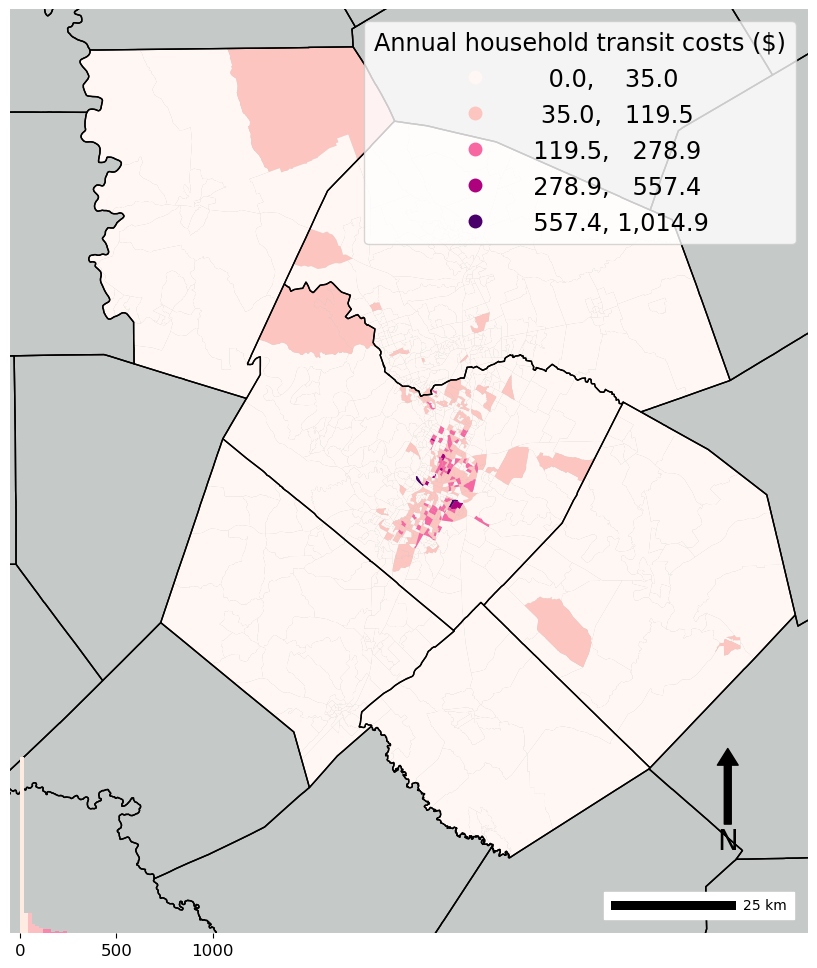

In [40]:
# Create single comprehensive subplots 
variable = transit_map['transitcost_hh'] # define target variable

### Plot data ###
fig, ax = plt.subplots(1, 1, figsize = (20, 12)) # set plot size
ax.axis([-98.6,-97,29.5,31.1]) # set axis

tx_county.to_crs(epsg = 4269).geometry.boundary.plot(color=None,edgecolor='k',linewidth = 1,ax=ax, zorder=2) # plot county boundary
tx_county.plot(color='#C5C9C7',edgecolor='grey',linewidth = 1,ax=ax, zorder=0)
 
transit_map.plot(column = variable,
            ax = ax,
            cmap = "RdPu",
            scheme='natural_breaks',
            k=5,
             legend=True,
            legend_kwds=(dict(fontsize='xx-large',fmt="{:,.1f}")),
            zorder = 1)

ax.axis('off') #Get rid of grids, and x/y axis

# add legend title
ax.get_legend().set_title("Annual household transit costs ($)",prop={'size':'xx-large'}) 


# add scalre bar
ax.add_artist(ScaleBar(100,"km", dimension="si-length", # add scale bar
                    length_fraction=0.25,scale_loc="right",border_pad=1,pad=0.5,location = "lower right"))

# add North arrow
x, y, arrow_length = 0.9, 0.2, 0.1
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=20,
            xycoords=ax.transAxes)


## add histogram as legend
scheme = mapclassify.NaturalBreaks(y=variable, k=5).bins # #extract the natural_break threshold values and get corresponding bins

legendgram(f =fig, # grab the figure, we need it
           ax = ax, # the axis to add the legend
           y = variable, # the attribute to map
           breaks = scheme, 
           # the natural breaks to induce color differences on
           pal = mplpals.RdPu_5, # the palette to use
          )

fig.savefig('images/annual_hh_transit_costs.png')

#### Annual household transit costs and transit stops distribution in the CAMPO center region

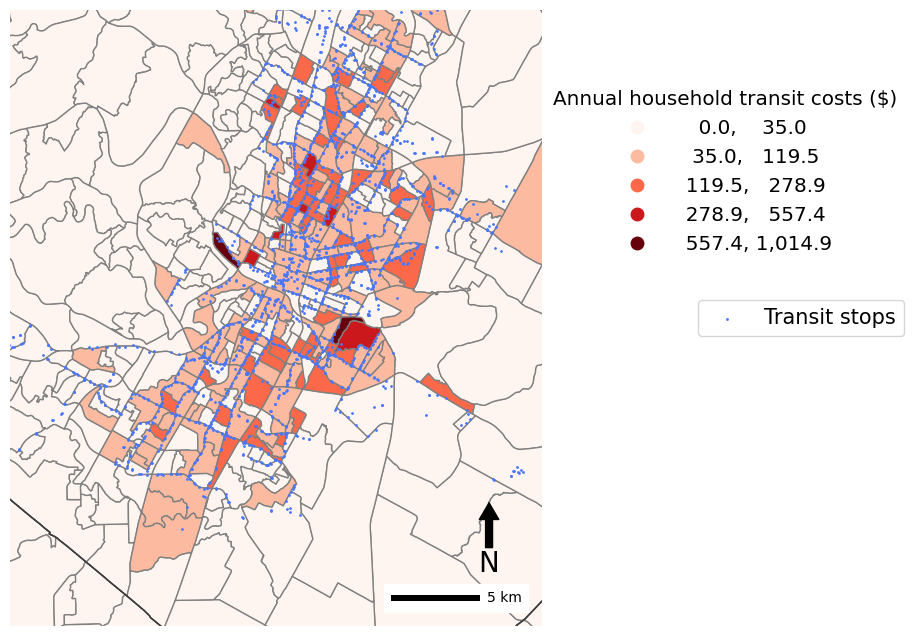

In [41]:
# Create single comprehensive subplots

variable = transit_map ['transitcost_hh'] # define our target variable


### Plot data ###

fig,ax = plt.subplots(1,1, figsize=(8,8)) # set plot size
ax.axis([-97.9,-97.6,30.1,30.4])
ax.axis('off') #Get rid of grids, and x/y axis


tx_county.plot(color='#C5C9C7',edgecolor='grey',linewidth = 1,ax=ax, zorder=0) # county boundary
tx_county.to_crs(epsg = 4269).geometry.boundary.plot(color=None,edgecolor='#3D3D3D',linewidth = 1,ax=ax, zorder=2) # county boundary

transit_map.plot(column = variable,
                 ax = ax,
                 colormap='Reds',
                 scheme='natural_breaks',
                 k=5,
                 legend=True,
                 legend_kwds=(dict(loc='upper right',
                            bbox_to_anchor=(1.7, .9),
                            fontsize='x-large',
                            #title="Annual household transit costs ($)",
                            frameon=False, fmt="{:,.1f}")),
                 edgecolor='grey',
                 zorder = 1)

ax.axis('off') #Get rid of grids, and x/y axis


 # add legend title
ax.get_legend().set_title("Annual household transit costs ($)",prop={'size':'x-large'})


g_gtfs.plot(column = "stop_id",markersize=1,color='#4876FF',ax=ax, label='Transit stops')

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='center right',fontsize=15)


# add scalre bar
ax.add_artist(ScaleBar(100,"km", dimension="si-length", # add scale bar
                    length_fraction=0.25,scale_loc="right",border_pad=1,pad=0.5,location = "lower right"))

# add North arrow
x, y, arrow_length = 0.9, 0.2, 0.1
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=14),
            ha='center', va='center', fontsize=20,
            xycoords=ax.transAxes)

fig.savefig('images/annual_hh_transit_costs_stops.png')

#### Transit stops distribution in the entire CAMPO region

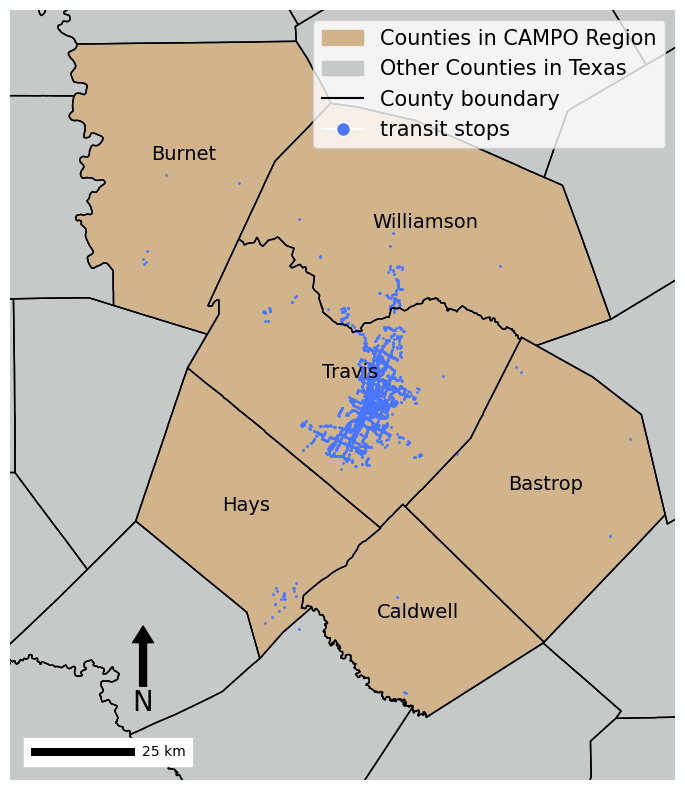

In [42]:
# Create single comprehensive subplots



# Create subplots - County mapping

fig, ax = plt.subplots(1, 1, figsize = (20, 10)) # set plot size

### Plot data ###

ax.axis([-98.6,-97,29.5,31.1]) # set axis

# county boundary
tx_county.plot(color='#C5C9C7',edgecolor='grey',linewidth = 1,ax=ax, zorder=0)
campo_county.plot(color='tan',edgecolor='grey',linewidth = 1,ax=ax, zorder = 1)
campo_county.apply(lambda x: ax.annotate(text=x.namelsad, xy=x.geometry.centroid.coords[0], ha='center', fontsize=14),axis=1)
tx_county.to_crs(epsg = 4269).geometry.boundary.plot(color=None,edgecolor='k',linewidth = 1,ax=ax, zorder=2)

# plot transit stops
g_gtfs.plot(column = "stop_id",markersize=1,color='#4876FF',ax=ax, label='Transit stops')

ax.axis('off') #Get rid of grids, and x/y axis

ax.add_artist(ScaleBar(100,"km", dimension="si-length", # add scale bar
                    length_fraction=0.25,scale_loc="right",border_pad=1,pad=0.5,location = "lower left"))

# add North arrow
x, y, arrow_length = 0.2, 0.2, 0.1
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=20,
            xycoords=ax.transAxes)


# add legend

campo_area = mpatches.Patch(color='tan', label='Counties in CAMPO Region')
texas_area = mpatches.Patch(color='#C5C9C7', label='Other Counties in Texas')

#Create Line Legend Entries
bd_c  = mlines.Line2D([], [], color='black', marker='',
                      markersize=15, label='County boundary')
point = mlines.Line2D([], [], marker='o', color='w', label='transit stops',
                          markerfacecolor='#4876FF', markersize=10)

plt.legend(handles=[campo_area, texas_area,bd_c,point],fontsize=15)



fig.savefig('images/campo_stops.png')